# 1. 1D Sequential Data and DNNs

### About this notebook

This notebook was used in the 50.039 Deep Learning course at the Singapore University of Technology and Design.

**Author:** Matthieu DE MARI (matthieu_demari@sutd.edu.sg)

**Version:** 1.0 (27/12/2022)

**Requirements:**
- Python 3 (tested on v3.9.6)
- 

### Imports and CUDA

In [1]:
# Matplotlib
import matplotlib.pyplot as plt
# Numpy
import numpy as np
# Torch
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

In [2]:
# Use GPU if available, else use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


### A Custom Time Series Dataset

...

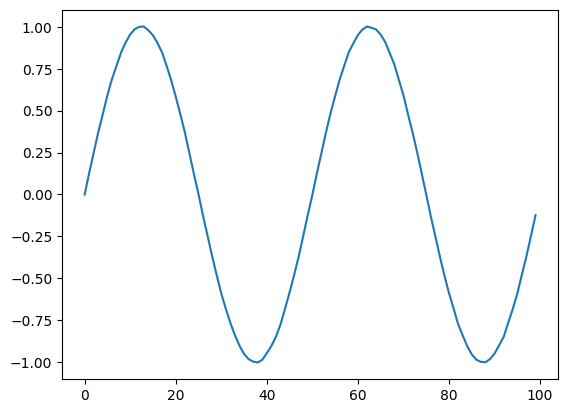

In [3]:
# Generate time series
np.random.seed(27)
datapoints = [np.sin(2*np.pi*i/50) + 1e-2*(np.random.random()-0.5) for i in range(1000)]
# Show the first 100 points
plt.plot(datapoints[:100])
plt.show()

In [4]:
# Our custom Dataset object
class CustomSeriesDataset(Dataset):
    def __init__(self, datapoints):
        self.inputs_number = 10
        self.outputs_number = 1
        self.datapoints = datapoints
        self.inputs = [datapoints[i:i+10] for i in range(len(datapoints) - 10)]
        self.outputs = [datapoints[i+10] for i in range(len(datapoints) - 10)]
        
    def __len__(self):
        return len(self.outputs)
        
    def __getitem__(self, index):
        inputs = torch.tensor(self.inputs[index]).float()
        outputs = torch.tensor(self.outputs[index]).float().reshape(-1)
        return inputs, outputs

In [5]:
# Create dataset and dataloader
dataset = CustomSeriesDataset(datapoints)
dataloader = DataLoader(dataset, batch_size = 32, shuffle = True)

### Using a DNN to predict the next point of the curve

...

In [6]:
class DNN(torch.nn.Module):
    
    def __init__(self):
        super(DNN, self).__init__()
        self.layers = torch.nn.Sequential(torch.nn.Linear(10, 32),
                                          torch.nn.ReLU(),
                                          torch.nn.Linear(32, 8),
                                          torch.nn.ReLU(),
                                          torch.nn.Linear(8, 1))
        
    def forward(self, inputs):
        out = self.layers(inputs)
        return out

In [7]:
model = DNN().to(device)
print(model)

DNN(
  (layers): Sequential(
    (0): Linear(in_features=10, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=1, bias=True)
  )
)


### A simple trainer function

As before, we could write a simple trainer function, like so.

In [8]:
def train(model, dataloader, num_epochs, learning_rate):
    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

    for epoch in range(num_epochs):
        for inputs, targets in dataloader:
            optimizer.zero_grad()
            outputs = model(inputs.to(device))
            loss = criterion(outputs, targets.to(device))
            loss.backward()
            optimizer.step()

        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {loss.item():.4f}")

In [9]:
# Train the model
model = DNN().to(device)
train(model, dataloader, num_epochs = 20, learning_rate = 0.001)

Epoch 1/20, Loss: 0.3601
Epoch 2/20, Loss: 0.1729
Epoch 3/20, Loss: 0.0344
Epoch 4/20, Loss: 0.0111
Epoch 5/20, Loss: 0.0016
Epoch 6/20, Loss: 0.0006
Epoch 7/20, Loss: 0.0003
Epoch 8/20, Loss: 0.0003
Epoch 9/20, Loss: 0.0002
Epoch 10/20, Loss: 0.0001
Epoch 11/20, Loss: 0.0001
Epoch 12/20, Loss: 0.0001
Epoch 13/20, Loss: 0.0001
Epoch 14/20, Loss: 0.0001
Epoch 15/20, Loss: 0.0000
Epoch 16/20, Loss: 0.0001
Epoch 17/20, Loss: 0.0001
Epoch 18/20, Loss: 0.0000
Epoch 19/20, Loss: 0.0001
Epoch 20/20, Loss: 0.0001


### Test model predictions

...

In [10]:
def test_display(seed, dataloader, model, device):
    # Fetch a datapoint
    torch.manual_seed(seed)
    data = next(iter(dataloader))
    inputs_test = data[0][0]
    outputs_test = data[1][0]

    # Display
    fig = plt.plot(range(10), inputs_test, "b", label = "Inputs")
    plt.scatter(10, outputs_test[0], c = "r", label = "Target")
    plt.scatter(10, model(inputs_test.to(device)).detach().cpu()[0], c = "g", marker = "x", label = "Prediction")
    plt.legend(loc = "best")
    plt.ylim(-1.05, 1.05)
    plt.show()

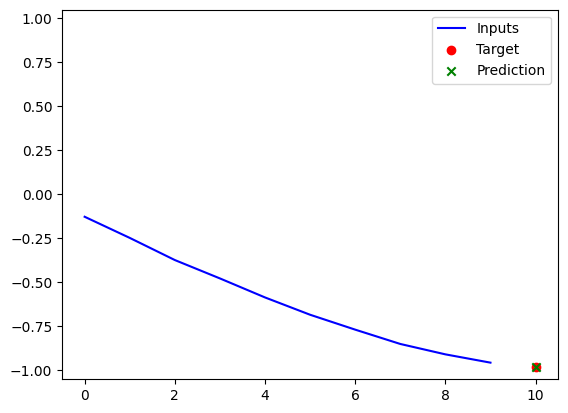

In [11]:
# Try it
test_display(seed = 17, dataloader = dataloader, model = model, device = device)

### What's next?

...